In [6]:
DATA_PATH = "/home/peter/Downloads/Project_CodeNet/data"
META_PATH = "/home/peter/Downloads/Project_CodeNet/metadata"

In [7]:
import os
import pandas as pd
import numpy as np
import rapidfuzz
import random

In [8]:
# Reader Functions


def init_df(path: str) -> pd.DataFrame:
    if not os.path.isfile(path):
        return
    df: pd.DataFrame = pd.read_csv(os.path.join(path))
    # Filter:
    df = df[['submission_id','status','language','user_id','date','accuracy']]
    df = df.loc['Python'  == df['language']]
    df = df.loc[1577836800 < df['date']] # > 2020 jan 1
    df = df[['submission_id','status']]
    return df


def pair_series(sr_x, sr_y, n_pairs, col_x: str, col_y: str) -> pd.DataFrame:
    assert len(sr_x) == len(sr_y)
    n_rows = len(sr_x)
    if n_rows < 2 * n_pairs:
        raise ValueError("Too many pairs.")
    inds = np.random.choice(n_rows, size=2 * n_pairs, replace=False)
    inds_x, inds_y = inds[:n_pairs], inds[n_pairs:]
    pairs = [
        (sr_x.iloc[i], sr_y.iloc[j]) for i,j in zip(inds_x,inds_y)
    ]
    return pd.DataFrame(pairs, columns=[f'{col_x}_x', f'{col_y}_y'])


def read_file(pid, sid):
    file_path = os.path.abspath(os.path.join(DATA_PATH, pid, 'Python'))
    fp =        os.path.abspath(os.path.join(file_path, f'{sid}.py'))
    with open(fp, 'r', encoding='utf-8') as f:
        return f.read()


def process_pid(pid: str, ac_data_map: dict, re_data_map: dict):
    MIN_PAIRS = 1
    
    file_path = os.path.abspath(os.path.join(DATA_PATH, pid, 'Python'))
    if not os.path.isdir(file_path):
        return
    files = os.listdir(file_path)
    if len(files) <= 5:
        return
    meta_path = os.path.join(META_PATH, f'{pid}.csv')
    print(meta_path)
    
    df = init_df(meta_path)
    df_acccepted = df.loc['Accepted'== df['status']]
    df_rejected  = df.loc['Accepted'!= df['status']]
    
    accepted_count, rejected_count = df_acccepted.shape[0], df_rejected.shape[0]
    print('accepted:', accepted_count)
    print('rejected:', rejected_count)
    
    n_rows = min(accepted_count, rejected_count)
    if n_rows < 2 * MIN_PAIRS:
        return
    
    df_acccepted = df_acccepted['submission_id']
    df_acccepted = df_acccepted.iloc[:n_rows]
    df_pp = pair_series(df_acccepted, df_acccepted, n_rows//2, 'sid', 'sid')
    
    df_rejected = df_rejected['submission_id']
    df_rejected = df_rejected.iloc[:n_rows]
    df_np = pair_series(df_acccepted, df_rejected, n_rows//2, 'sid', 'sid')
    
    def create_pair(pid, sid_x, sid_y, label: int):
        return {
            "pid"  : pid,
            "sid_x": sid_x,
            "sid_y": sid_y,
            "src_x": read_file(pid, sid_x),
            "src_y": read_file(pid, sid_y),
            "label": label
        }
    
    if n_positive_pairs := df_pp.shape[0]:
        ssize = n_positive_pairs//2
        ac_rows = [tuple(row) for _, row in df_pp.sample(ssize).iterrows()]
        ac_data_map[pid] = [
            create_pair(pid, sid_x, sid_y, label=1)
            for sid_x, sid_y in ac_rows
        ]

    if n_negative_pairs := df_np.shape[0]:
        ssize = n_negative_pairs//2
        re_rows = [tuple(row) for _, row in df_np.sample(ssize).iterrows()]
        re_data_map[pid] = [
            create_pair(pid, sid_x, sid_y, label=0)
            for sid_x, sid_y in re_rows
        ]


def test():
    _pids = os.listdir(DATA_PATH)
    _pids = random.sample(_pids, k=1)
    process_pid('p03200', {}, {})

In [9]:
test()

/home/peter/Downloads/Project_CodeNet/metadata/p03200.csv
accepted: 612
rejected: 333


In [10]:
# Reading data

SAMPLE_SIZE = 2000

_pids = os.listdir(DATA_PATH)
_pids = random.sample(_pids, k=min(SAMPLE_SIZE, 4053))

ac_data = {}
re_data = {}

print('Starting...')
print(f'Processing {len(_pids)} problems.')

for _pid in _pids:
    process_pid(_pid, ac_data, re_data)

print('Data gathered...')

pp_output = []
np_output = []
for pid in ac_data:
    for data in ac_data[pid]:
        pp_output.append((pid,
            data['sid_x'], data['sid_y'],
            data['src_x'], data['src_y'],
            data['label'],))
for pid in re_data:
    for data in re_data[pid]:
        np_output.append((pid,
            data['sid_x'], data['sid_y'],
            data['src_x'], data['src_y'],
            data['label'],))

print(f'POSITIVE pairs created... LENGTH: {len(pp_output)}')
print(f'NEGATIVE pairs created... LENGTH: {len(np_output)}')

pp_output = list(sorted(set(pp_output), key = lambda x:(x[0],x[1])))
np_output = list(sorted(set(np_output), key = lambda x:(x[0],x[1])))

pp_len, np_len = len(pp_output), len(np_output)

print(f'POSITIVE pair content filtered... LENGTH: {pp_len}')
print(f'NEGATIVE pair content filtered... LENGTH: {np_len}')

print('DONE')

columns = ['pid','sid_x', 'sid_y', 'src_x', 'src_y', 'label']
# positive pairs
pp_output = pd.DataFrame(pp_output, columns=columns)
# negative pairs
np_output = pd.DataFrame(np_output, columns=columns)

Starting... 
 Processing 2000 problems.
/home/peter/Downloads/Project_CodeNet/metadata/p02294.csv
accepted: 8
rejected: 0
/home/peter/Downloads/Project_CodeNet/metadata/p00028.csv
accepted: 129
rejected: 0
/home/peter/Downloads/Project_CodeNet/metadata/p03109.csv
accepted: 820
rejected: 255
/home/peter/Downloads/Project_CodeNet/metadata/p03355.csv
accepted: 226
rejected: 246
/home/peter/Downloads/Project_CodeNet/metadata/p03845.csv
accepted: 838
rejected: 141
/home/peter/Downloads/Project_CodeNet/metadata/p03288.csv
accepted: 854
rejected: 168
/home/peter/Downloads/Project_CodeNet/metadata/p03249.csv
accepted: 3
rejected: 3
/home/peter/Downloads/Project_CodeNet/metadata/p00176.csv
accepted: 3
rejected: 0
/home/peter/Downloads/Project_CodeNet/metadata/p03190.csv
accepted: 0
rejected: 1
/home/peter/Downloads/Project_CodeNet/metadata/p02599.csv
accepted: 411
rejected: 1917
/home/peter/Downloads/Project_CodeNet/metadata/p00150.csv
accepted: 2
rejected: 0
/home/peter/Downloads/Project_CodeN

In [11]:
# Calculating rapid fuzz

def run_rf(a,b): return rapidfuzz.fuzz.ratio(a,b)

pp_output['rf_ratio'] = pp_output.apply(lambda row: run_rf(row['src_x'], row['src_y']), axis=1)
np_output['rf_ratio'] = np_output.apply(lambda row: run_rf(row['src_x'], row['src_y']), axis=1)

In [12]:
# Rapid fuzz counts
print('pp gt 80%:', (pp_output['rf_ratio']>80).sum())
print('np gt 80%:', (np_output['rf_ratio']>80).sum())

pp gt 80%: 3385
np gt 80%: 1565


Matplotlib is building the font cache; this may take a moment.


Text(0.5, 0, 'rf ratio on positive pairs')

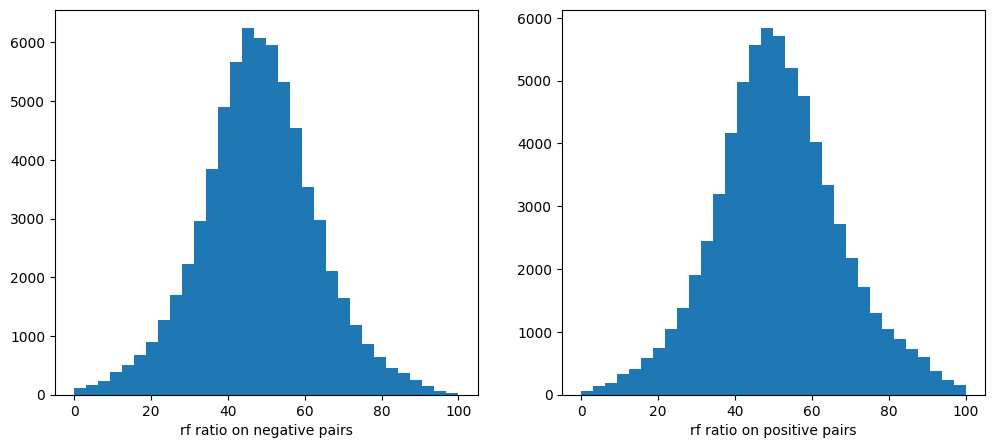

In [14]:
# Rapid fuzz histograms
import matplotlib.pyplot as plt
res = 32
# histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].hist(np_output['rf_ratio'], bins=res)
ax[0].set_xlabel('rf ratio on negative pairs')
ax[1].hist(pp_output['rf_ratio'], bins=res)
ax[1].set_xlabel('rf ratio on positive pairs')

In [15]:
# Filtering and sampling
pp_output = pp_output.sample(5000)
#np_output = np_output[np_output['rf_ratio'] > 80]
np_output = np_output.sample(5000)

In [16]:
# Exporting
pp_output = pp_output[columns]
np_output = np_output[columns]
output = pd.concat([pp_output, np_output], ignore_index=True)
output.to_csv('training_1.csv')

In [17]:
df = pd.read_csv('training_1.csv')
len(set(df['pid']))

514